<a href="https://colab.research.google.com/github/nrysam/CNN-Car-Parts/blob/main/CNN_based_Car_Part_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Get the dataset
!gdown --id 1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2
From (redirected): https://drive.google.com/uc?id=1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2&confirm=t&uuid=6efe29b8-d385-4543-b772-77a0d34e2084
To: /content/car parts 50.zip
100% 150M/150M [00:02<00:00, 60.2MB/s]


In [3]:
# Unzip the dataset
!unzip -q 'car parts 50.zip' -d dataset

In [4]:
#define the training, validation, testing base directories
train_dir = 'dataset/car parts 50/train'
validation_dir = 'dataset/car parts 50/valid'
test_dir = 'dataset/car parts 50/test'

In [5]:
#Define Target Size, Batch Size, and Class for Generators
TARGET_SIZE = (150,150)
BATCH_SIZE = 32
CLASS_MODE = 'sparse'

In [6]:
def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the validation images
    TESTING_DIR (string): directory path containing the testing images
  Returns:
    train_generator, validation_generator, testing_generator: tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class for the training dataset with augmentation
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40,
      width_shift_range=.2,
      height_shift_range=.2,
      shear_range=.2,
      zoom_range=.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE
  )

  # Instantiate the ImageDataGenerator class for the validation dataset
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE
  )

  # Instantiate the ImageDataGenerator class for the testing dataset
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(
      TESTING_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE,
      shuffle = False
  )

  return train_generator, validation_generator, test_generator

In [7]:
train_generator, validation_generator, test_generator = train_val_test_generators(train_dir, validation_dir, test_dir)

Found 8739 images belonging to 50 classes.
Found 250 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


In [8]:
#Define the model

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(50, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    return model

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for unbalanced training data
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights_dict = dict(zip(classes, class_weights))

In [10]:
#Add callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [11]:
# Save the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 3.7530 - acc: 0.0603
Epoch 1: val_acc improved from -inf to 0.05200, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 77s 236ms/step - loss: 3.7530 - acc: 0.0603 - val_loss: 3.7974 - val_acc: 0.0520
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 3.4016 - acc: 0.1166
Epoch 2: val_acc improved from 0.05200 to 0.18800, saving model to best_model.h5
274/274 [==============================] - 59s 216ms/step - loss: 3.4016 - acc: 0.1166 - val_loss: 2.9902 - val_acc: 0.1880
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 3.0904 - acc: 0.1776
Epoch 3: val_acc improved from 0.18800 to 0.26400, saving model to best_model.h5
274/274 [==============================] - 60s 219ms/step - loss: 3.0904 - acc: 0.1776 - val_loss: 2.7632 - val_acc: 0.2640
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 2.8799 - acc: 0.2298
Epoch 4: val_acc improved from 0.26400 to 0.32400, saving model to best_model.h5
274/274 [==============================] - 61s 222ms/step - loss: 2.8799 - acc: 0.2298 - val_loss: 2.4833 - v

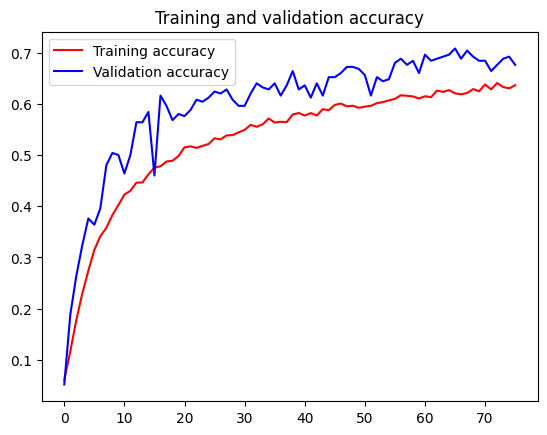

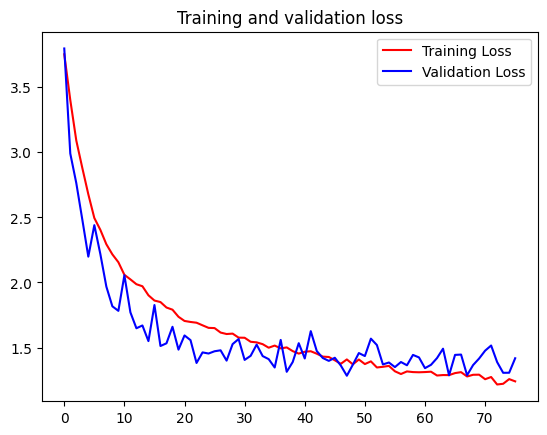

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy chart
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Loss chart
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
# Evaluate the Model
import math

test_steps = math.ceil(test_generator.n / test_generator.batch_size)

results = model.evaluate(test_generator, steps=test_steps)
print('test loss, test acc:', results)

8/8 [==============================] - 0s 33ms/step - loss: 1.1568 - acc: 0.6760
test loss, test acc: [1.1568105220794678, 0.6759999990463257]


In [14]:
# Create a prediction from model
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Define true_classes and class_labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Make sure that predicted_classes and true_classes have the same length
if len(predicted_classes) > len(true_classes):
    predicted_classes = predicted_classes[:len(true_classes)]  # Trim predictions to match true_classes length

8/8 [==============================] - 0s 32ms/step


In [15]:
# Use scikit-learn to generate a detailed classification report
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                      precision    recall  f1-score   support

      AIR COMPRESSOR       0.71      1.00      0.83         5
          ALTERNATOR       1.00      0.80      0.89         5
             BATTERY       0.80      0.80      0.80         5
       BRAKE CALIPER       0.60      0.60      0.60         5
           BRAKE PAD       0.80      0.80      0.80         5
         BRAKE ROTOR       1.00      0.40      0.57         5
            CAMSHAFT       1.00      0.40      0.57         5
          CARBERATOR       0.80      0.80      0.80         5
        CLUTCH PLATE       0.80      0.80      0.80         5
         COIL SPRING       0.80      0.80      0.80         5
          CRANKSHAFT       0.50      0.60      0.55         5
       CYLINDER HEAD       0.40      0.80      0.53         5
         DISTRIBUTOR       1.00      0.80      0.89         5
        ENGINE BLOCK       1.00      0.60      0.75         5
        ENGINE VALVE       1.00      1.00      1.00         5
       

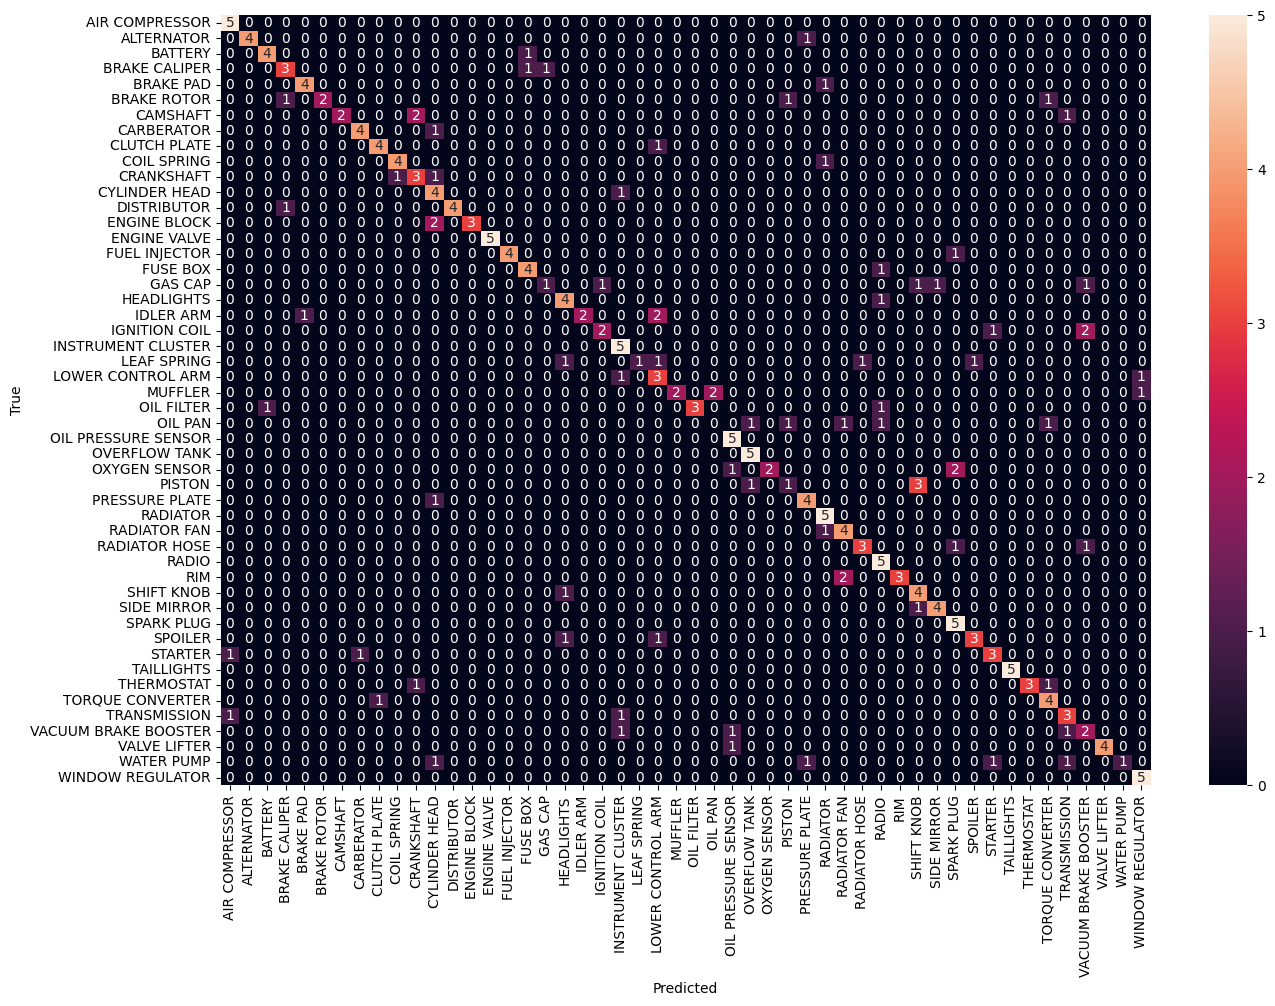

In [16]:
# Add Confusion matrix to visualize the performance across the different classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Conclusion**

Each cell in our confusion matrix represents the number of predictions made by our model for each class. For instance, a zero means no instances of a class were predicted in that category—either correctly or incorrectly, depending on the location of the zero. Conversely, a five indicates that five instances were predicted in that category, again either correctly or incorrectly. Correct predictions are shown on the diagonal, where the predicted class matches the actual class. Errors are shown off the diagonal, where there is a discrepancy between prediction and reality.

Ideally the diagonal should have five. But the plot above shows that some classes in the diagonal does not have five and have one or two instead. This means that the model have some room for improvement to raise the accuracy. A lot of four and fives in the diagonal means the model accurately predicts the car parts.

In [34]:
#Testing the model prediction
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array

# Load the model
model = load_model('best_model.h5')

# Load class labels using the train_generator's class_indices
class_labels = {v: k for k, v in train_generator.class_indices.items()}

Saving GMM_CAMSHAFT.jpg to GMM_CAMSHAFT (3).jpg
1/1 [==============================] - 0s 79ms/step
Filename: GMM_CAMSHAFT (3).jpg
Predicted class: CAMSHAFT
Confidence: 84.20%


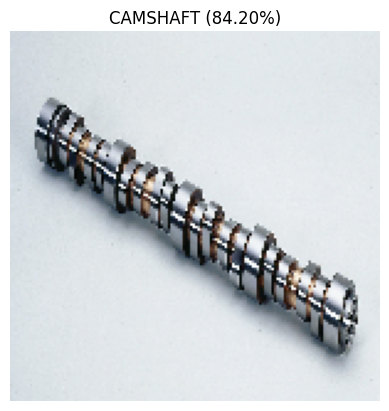

In [27]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()

Saving Radiator.jpeg to Radiator (1).jpeg
1/1 [==============================] - 0s 19ms/step
Filename: Radiator (1).jpeg
Predicted class: RADIATOR
Confidence: 69.77%


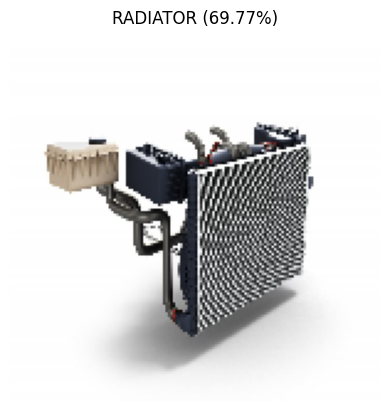

In [28]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()

Saving 5.jpg to 5.jpg
1/1 [==============================] - 0s 18ms/step
Filename: 5.jpg
Predicted class: PISTON
Confidence: 99.65%


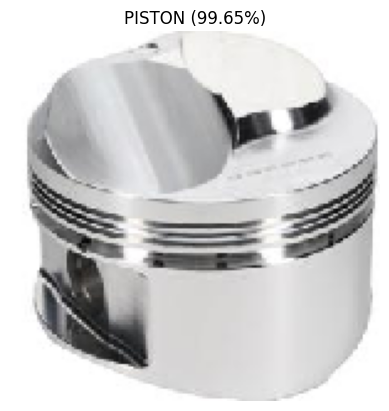

In [31]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()

Saving 4.jpg to 4.jpg
1/1 [==============================] - 0s 18ms/step
Filename: 4.jpg
Predicted class: OIL PRESSURE SENSOR
Confidence: 69.33%


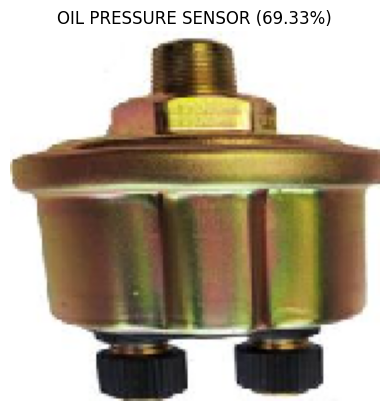

In [32]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()

Saving brake-system-2709406_1920.png to brake-system-2709406_1920.png
1/1 [==============================] - 0s 19ms/step
Filename: brake-system-2709406_1920.png
Predicted class: RIM
Confidence: 58.09%


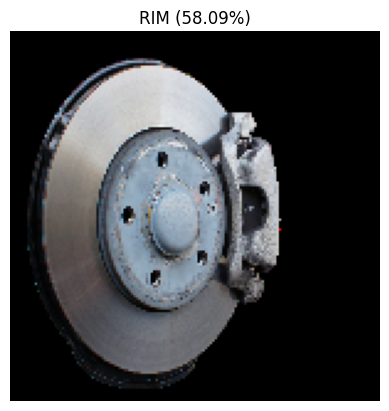

In [33]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()

Saving wheel-rim-254714_1280.jpg to wheel-rim-254714_1280.jpg
1/1 [==============================] - 0s 73ms/step
Filename: wheel-rim-254714_1280.jpg
Predicted class: RIM
Confidence: 58.06%


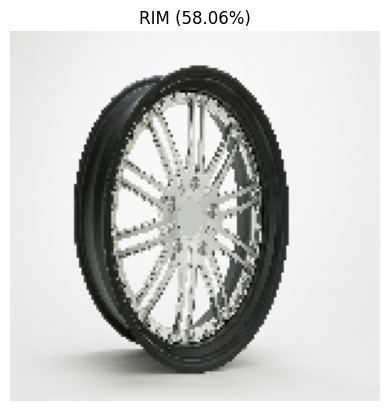

In [35]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()